In [1]:
import arcgis
import arcgiskey
from arcgis.gis import GIS
from arcgis.geometry import *
from ipywidgets import *
import geopandas as gpd
import pandas as pd
import numpy as np
import arcgis.network as network
import arcgis.geocoding as geocoding
from arcgis.features import (
    FeatureLayer,
    FeatureSet,
    FeatureCollection,
    FeatureLayerCollection,
    GeoAccessor,
    GeoSeriesAccessor,
)
import arcgis.features.use_proximity as use_proximity
from arcgis.geoenrichment import *
from arcgis.map.symbols import PictureMarkerSymbolEsriPMS
from arcgis.map.symbols import (
    SimpleFillSymbolEsriSFS,
    SimpleLineSymbolEsriSLS,
    SimpleMarkerSymbolEsriSMS,
)
from arcgis.map import renderers
from arcgis.map.renderers import SimpleRenderer
from arcgis.map.symbols import SimpleFillSymbolEsriSFS, SimpleFillSymbolStyle
from arcgis.map.symbols import SimpleLineSymbolEsriSLS, SimpleLineSymbolStyle
from shapely.geometry import (
    Point,
    MultiPoint,
    LineString,
    MultiLineString,
    Polygon,
    MultiPolygon,
)
from shapely.wkt import loads

gis = GIS(username = arcgiskey.USERNAME, password = arcgiskey.PASSWORD)

# 1) Project Title: Identifying points of Traffic with reasons in San Diego

Team Members: Kevin Wong (A17280855) and Lukas Fullner (A16945107) 

Class: DSC 170 Winter 2025

# 2) Questions we want to address, and their importance

Traffic Pattern Analysis
* How does traffic in urban, suburban, and rural areas differ? Specifically, what type of accidents happen most often in each respective category?
* What are the most accident-prone intersections, highways, and roads in San Diego? Identify high risk areas based on accident frequency and severity

Demographic Factors: 
* Are accidents more frequent in areas with certain demographic characteristics?
* Do different types of accidents correlate with socioeconimic factors?

When traffic accidents are portrayed on the news, they are cited as being avoidable and oftentimes the cause of reckless driving, whether that be through sleepy drivers or those under the influence. However, we propose that oftentimes, traffic is not solely caused by reckless driving and individual driver behvaior. Other factors - such as socioeconomic conditions, infrastructure design, and traffic congrestion - play a significant role and are more measurable than human error. 

By identifying areas with high traffic volume and frequent accidents (relative to their area), we aim to create an interactive map highlighting accident-prone locations and potential contributing factors. This will provide a data-driven approach to understanding traffic safety in San Diego county and offer potential areas of improve to reduce accidents.

# 3) Background and Literature

GIS in Traffic Accident Analysis

* GIS has been extensively used to study the spatial distribution of traffic accidents, identifying hotspots and danger points in road traffic. For instance, the [FeGIS](https://bmdv.bund.de/SharedDocs/DE/Artikel/DG/mfund-projekte/frueherkennung-von-gefahrenstellen-im-strassenverkehr-fegis.html) (Early Detection of Dangerous Areas in road traffic) project in Germany helped identify these "danger points", preventing accidents through timely warnings of danger zones for pedestrians and road users. It offered an outline for proactive identification of danger for EU Road Safety Policy

Statistical Methods in Traffic Safety Research 

* Statistical and econometrical methods for analyzing crash data and understanding the factors that influence accident occurrences and severities are essential to our project. Researchers like [Fred Mannering](https://en.wikipedia.org/wiki/Fred_Mannering) have contributed significantly to this field, developing models that account for accident frequency and severity based on road conditions, type, and more. 

Tools for Spaital Analysis in Traffic Studies

* Tools like [CrimeStat](https://en.wikipedia.org/wiki/CrimeStat) offer spatial statistical functionalities that can be applied to traffic accident analysis. CrimeStat's spatial analytical methods have been adapted for various applications, like finding accident hotspots and modeling travel demand related to traffic accidents.

# 4) Libaries and Modules

* Pandas - To handle dataframes and to preprocess data
* GeoPandas — Used to determine the geometry of certain places in San Diego. Also used to help spatial join and create buffers around areas to analyze them.
* ArcGIS Online — Mainly used for Geoenrichment as well as mapping traffic patterns around a map of San Diego. Additionally, used to search for data in ArcGIS to see which areas have a lot of traffic and see what correlations are implied with it. 

# 5) Data Sources:

SANDAG: Safety - Collions (SWITRS) 2023 
* This data focuses on collision data for San Diego within 2022, due to it's completeness. It currently has over 10000 collisions in San Diego County. Primarily, it uses the Statewide Integrated Traffic Records System (SWITRS) as a database and process data gathered from a collision scene. We take this specifically from SANDAG due to their reliability as a data distributor for spatial data with the help of California Highway Patrol. We will be using data primarily from 2023. 

ArcGIS Online USA Counties 
* Used to determine the counties in the United States; additionally, used for geoenrichment to find population density

In [4]:
# read data and convert into a spatial dataframe
data = gpd.read_file("data/collision_data_2022.csv")
data = data.drop(columns = ['Reservation sandag', 'Shape', 'CASE ID', 'X', 'Y'])

# conver to floats in order to make sure the spatial references work
data['LONGITUDE sandag'] = data['LONGITUDE sandag'].astype(float)
data['LATITUDE sandag'] = data['LATITUDE sandag'].astype(float)
sdf = GeoAccessor.from_xy(data, x_column='LONGITUDE sandag', y_column='LATITUDE sandag', sr = 4326)

In [5]:
# convert into a feature layer -> DON'T RUN AGAIN, ALREADY CREATED
# feature_layer = sdf.spatial.to_featurelayer(
#     title = "Collision Data SD County 2022",
#     gis = gis, 
#     tags = ["Collision", "Data", "2022"],
#     overwrite = False,
#     sanitize_columns = True,
#     service_name = "Collision_Data_San_Diego_County_2022"
# )

In [6]:
collision_layer = gis.content.search(query = f"owner:{arcgiskey.USERNAME}", item_type = "Feature Layer", outside_org = True)[2]
collision_fl = gis.content.get(collision_layer.id).layers[0]
collision_sdf = collision_fl.query().sdf

In [7]:
# find county barrier for San Dieg
counties = gis.content.search("USA Counties generalized", "Feature Layer", outside_org=True)[4]
counties_fl = gis.content.get(counties.id).layers[0]
sd_county_sdf = counties_fl.query("NAME = 'San Diego County'", return_geometry=True).sdf
sd_county_gdf = gpd.GeoDataFrame(sd_county_sdf).set_geometry("SHAPE")
sd_county_gdf = sd_county_gdf.set_crs("4326")
sd_county_gdf = sd_county_gdf.to_crs("3857")

# find US zip codes for San Diego
zip_codes = gis.content.search("zip code", item_type = "Feature Layer", outside_org = True)[2]
zip_codes_fl = gis.content.get(zip_codes.id).layers[0]
california_zip_codes_sdf = zip_codes_fl.query(where = "STATE = 'CA'").sdf
ca_zip_codes_gdf = gpd.GeoDataFrame(california_zip_codes_sdf).set_geometry("SHAPE")
ca_zip_codes_gdf = ca_zip_codes_gdf.set_crs("3857")

# spatial join these two to find zip codes that lie within San Diego County (add buffer to get rid of inconsistencies)
sd_county_gdf['SHAPE'] = sd_county_gdf['SHAPE'].buffer(5000)
sd_zip_codes = ca_zip_codes_gdf.sjoin(sd_county_gdf, predicate = 'within')

# create 'density_class' based on 'pop_sqmi_l'
def classify_density(pop_density):
    if pop_density > 1000:
        return "Urban"
    elif pop_density > 200:
        return "Suburban"
    else:
        return "Rural"

# fill the missing value with data from 2023
sd_zip_codes["POP_SQMI_left"] = sd_zip_codes["POP_SQMI_left"].fillna(3860)
sd_zip_codes["density_class"] = sd_zip_codes["POP_SQMI_left"].apply(classify_density)

Exception: Cannot perform query. Invalid query parameters.
'Invalid field: STATE' parameter is invalid
(Error Code: 400)

In [ ]:
# convert into feature layer -> don't run again, already created
# sd_zip_sdf = GeoAccessor.from_geodataframe(
#     sd_zip_codes, column_name = "SHAPE"
# )
# zip_code_fl = sd_zip_sdf.spatial.to_featurelayer(
#     title = "San Diego County Zip Codes",
#     gis = gis,
#     tags = ["San Diego", "Zip Codes", "County"],
#     overwrite = False,
#     sanitize_columns = True,
#     service_name = "San_Diego_County_ZipCode_Data"
# )

In [8]:
zip_code_layer = gis.content.search(
    query=f"owner:{arcgiskey.USERNAME}", item_type="Feature Layer"
)[1]
sd_zip_codes_fl = gis.content.get(zip_code_layer.id).layers[0]
sd_zip_codes_sdf = sd_zip_codes_fl.query().sdf

In [9]:
map1 = gis.map("San Diego, CA")

# population density renderer
population_density_renderer = {
    "type": "uniqueValue",
    "field1": "density_cl",
    "uniqueValueInfos": [
        {
            "value": "Urban",
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [252, 101, 66, 100],  # Transparent fill
                "outline": {
                    "color": [252, 101, 66, 255],  # Red outline for urban areas
                    "width": 1.5,
                },
            },
            "label": "Urban",
        },
        {
            "value": "Suburban",
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [162, 190, 149, 100],  # Transparent fill
                "outline": {
                    "color": [162, 190, 149, 255],  # Green outline for suburban areas
                    "width": 1.5,
                },
            },
            "label": "Suburban",
        },
        {
            "value": "Rural",
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [55, 94, 151, 100],  # Transparent fill
                "outline": {
                    "color": [55, 94, 151, 255],  # Blue outline for rural areas
                    "width": 1.5,
                },
            },
            "label": "Rural",
        },
    ],
}

map1.content.add(
    sd_zip_codes_fl, drawing_info={"renderer": population_density_renderer}
)
map1.content.add(collision_fl)
map1.legend.enabled = True
map1


Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13075789.689488532, 'ymin': 3818273.910…

# 6) Expected Data Cleaning

Some relevant data quality issues is data age. We want to use more modern data, but also have data that is complete and accurate. We already did this with the collision data, as 2023 and 2024 data were incomplete, which means we had to settle for 2022. However, 2022 is a decent predictor of 2024 and 2025, as the bounceback from COVID had already begun. Fortunately, a topic like traffic accidents is a pretty popular and normal set that is used in data analysis, so there shouldn’t be any problems with it’s metadata. I would expect a lot of the data provided in SANDAG to be mostly reputable, but I do expect some problems with street names or areas that might not have been mapped out that well in the data. We will also encounter the issue of incomplete reporting, where the SANDAG data may not have full information reported for certain fields meaning we will have to impute some data or otherwise acount for the missing data.

Additionally, some data cleaning we had to do was due to the buffer, since the boundaries of the county weren't 100% accurate to the boundaries of the zip code. We had to place a 5000 meter buffer on the county in order to get all of the zip codes in the county.

# 7) Plan of Analysis

* Data Exploration - Look through the data to see what exactly there is to analyze. For example, for traffic accidents, we could analyze how serious an accident is, or see what type of accident it is (this could be a car-car accident, car-person accident, car-bike accident, etc)
* Data Analysis - We could look at concentrated places on our map where accidents occur more, and geoenrich a specific part (i.e. Downtown San Diego) to understand why something is happening. For instance, if we saw a lot of traffic in an area along with a lot of pedestrian violence, there might be a higher chance that an accident occurs. Similarly, we could also check restaurants that serve alcohol, and analyze whether or not areas near the restaurants could serve as an indication of an accident happening.
* Machine Learning/Modeling - We want to model whether or not accidents are more likely to occur based on a number of variables that we had geoenriched. This could be the aforementioned # of restaurants that serve alcohol, or any sort of number of features that we geoenriched previously, and make sure we have a set of test areas that could be predicted. We could also predict the type of accident that happened spatially, with the same features. For our business case, we could identify certain zip codes or areas that contain a lot of traffic, and see reasons why they might be so traffic heavy compared to other zip codes. 


For the first question, we observed whether or not collisions were more likely to occur in urban, rural, or suburban areas, as well as which zip codes had the highest collision density. We found per square kilometer, Rural Areas only had 0.001673 collisions, Suburban Areas had 0.003585 collisions, while Urban had by far the highest collision density, with 0.021066 collisions per square kilometer. We also noticed that when we measured collision density in individual zip codes, those closest to the coast and downtown near the freeway had the highest collision rate, which is to be expected due to their frequent usage.

In [10]:
# Let's see if accidents are more prone to happening in urban, suburban, or rural areas
collision_gdf = gpd.GeoDataFrame(collision_sdf, geometry=collision_sdf.SHAPE)
sd_zip_codes_gdf = gpd.GeoDataFrame(sd_zip_codes_sdf, geometry=sd_zip_codes_sdf.SHAPE)
zip_code_collisions = collision_gdf.sjoin(sd_zip_codes_gdf, predicate="within")

In [11]:
# see which zip codes are most accident prone
collision_counts = zip_code_collisions.groupby("zip_code").size().rename("Total Collisions")

# convert from m2 -> km2
total_area = zip_code_collisions.groupby("zip_code")['shape_area'].sum().rename("Total Area") / 1000000
collision_density = (collision_counts / total_area).rename("Collision Density")

zip_code_collision_density = sd_zip_codes_sdf.merge(collision_density, left_on = "zip_code", right_index = True, how = "outer")
zip_code_collision_density['Col_Dens_km'] = zip_code_collision_density['Collision Density'].fillna(0)
zip_code_collision_density = zip_code_collision_density.set_geometry("SHAPE")
zip_code_collision_density = zip_code_collision_density.set_crs("3857")

In [ ]:
# zip_collision_density_sdf = GeoAccessor.from_geodataframe(
#     zip_code_collision_density, column_name="SHAPE"
# )
# zip_collision_density_fl = zip_collision_density_sdf.spatial.to_featurelayer(
#     title="San Diego County Zip Code Collision Density",
#     gis=gis,
#     tags=["San Diego", "Zip Codes", "Collision Density"],
#     overwrite=False,
#     sanitize_columns=True,
#     service_name="San_Diego_County_Zip_Code_Collision_Density",
# )

In [12]:
zip_collision_layer = gis.content.search(query=f"owner:{arcgiskey.USERNAME}", item_type="Feature Layer")[4]
zip_col_fl = gis.content.get(zip_collision_layer.id).layers[0]
zip_col_sdf = zip_col_fl.query().sdf

IndexError: list index out of range

In [13]:
map2 = gis.map("San Diego, CA")
# Apply a graduated colors renderer
density_renderer = {
    "type": "classBreaks",
    "field": "col_dens_k",
    "classificationMethod": "esriClassifyQuantile",
    "minValue": 0,
    "maxValue": 1.3,
    "defaultSymbol": {
        "type": "esriSFS",
        "style": "esriSFSSolid",
        "color": [255, 255, 255, 100],
        "outline": {
            "type": "esriSLS",
            "style": "esriSLSSolid",
            "color": [110, 110, 110, 255],
            "width": 0.5,
        },
    },
    "defaultLabel": "No Data",
    "legendOptions": {"title": "Collision Density (per sq km)"},
    "classBreakInfos": [
        {
            "classMaxValue": np.percentile(zip_col_sdf["col_dens_k"], 25),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [204, 236, 230, 100],  # Light blue-green
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"0 - {np.round(np.percentile(zip_col_sdf['col_dens_k'], 25))} people/km²: 1st-25th Percentile",
        },
        {
            "classMaxValue": np.percentile(zip_col_sdf["col_dens_k"], 50),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [153, 216, 201, 100],  # Medium blue-green
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"{np.round(np.percentile(zip_col_sdf['col_dens_k'], 25))} - {np.round(np.percentile(zip_col_sdf['col_dens_k'], 50))} people/km²: 25th-50th Percentile",
        },
        {
            "classMaxValue": np.percentile(zip_col_sdf["col_dens_k"], 75),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [102, 194, 164, 100],  # Darker blue-green
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"{np.round(np.percentile(zip_col_sdf['col_dens_k'], 50))} - {np.round(np.percentile(zip_col_sdf['col_dens_k'], 75))} people/km²: 50th-75th Percentile",
        },
        {
            "classMaxValue": np.percentile(zip_col_sdf["col_dens_k"], 100),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [0, 109, 44, 255],  # Dark green
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"{np.round(np.percentile(zip_col_sdf['col_dens_k'], 75))} - {np.round(np.percentile(zip_col_sdf['col_dens_k'], 100))} people/km²: 75th-100th Percentile",
        },
    ],
}


# Add the layer with the heatmap renderer to your map
map2.content.add(zip_col_fl, drawing_info={"renderer": density_renderer})
map2.legend.enabled = True
map2

NameError: name 'zip_col_sdf' is not defined

Here, let's answer the question about the roads and highways that are most prone to collisions.

In [14]:
# Lets now evaluate lane size relative to collisions
# read data and convert into a spatial dataframe
road_data = gpd.read_file("data/SOC_Road_data.csv")
road_data = road_data.drop(columns = ['Speed 2021 MPH', '2021 AADT Range', "1 year AADT % change", "1 year Speed % change"])



# conver to floats in order to make sure the spatial references work
#data['LONGITUDE sandag'] = data['LONGITUDE sandag'].astype(float)
#data['LATITUDE sandag'] = data['LATITUDE sandag'].astype(float)
#sdf = GeoAccessor.from_xy(data, x_column='LONGITUDE sandag', y_column='LATITUDE sandag', sr = 4326)

In [15]:
cols = ['osm_id', 'Speed Limit MPH', 'Lanes', 'Length', 'Speed 2022 MPH']

road_data = road_data.convert_dtypes()
road_data['Speed 2022 MPH'] = road_data['Speed 2022 MPH'].replace('<NA>', '0')
road_data[cols] = road_data[cols].apply(pd.to_numeric, errors='coerce', axis=1)
#road_data['Speed 2022 MPH'] = road_data['Speed 2022 MPH'].astype(float)

In [76]:
road_gdf = gpd.GeoDataFrame(road_data)
road_gdf['geometry'] = road_gdf['geometry'].apply(lambda x: loads(x) if isinstance(x, str) else x)
road_gdf = road_gdf.set_geometry("geometry")
road_gdf = road_gdf.set_crs(4326)

In [75]:
road_gdf.head(5)

,osm_id,Street Name,Highway,Lanes,Speed Limit MPH,Length,Direction,PeakPeriod,Speed 2022 MPH,2022 AADT Range,geometry
0,153343706.0,"Orange Avenue, CA 75",primary,2.0,40.0,43.61,S,AM,18.0,"10,000-19,999","LINESTRING (-117.17894 32.68361, -117.17892 32..."
1,153343706.0,"Orange Avenue, CA 75",primary,2.0,40.0,43.61,S,PM,16.9,"10,000-19,999","LINESTRING (-117.17894 32.68361, -117.17892 32..."
2,161508068.0,Nimitz Boulevard,primary,-1.0,40.0,41.71,SE,AM,16.2,"5,000-9,999","LINESTRING (-117.2217 32.72605, -117.22163 32...."
3,161508068.0,Nimitz Boulevard,primary,-1.0,40.0,41.71,SE,PM,16.5,"5,000-9,999","LINESTRING (-117.2217 32.72605, -117.22163 32...."
4,186470511.0,Pacific Highway,primary,2.0,50.0,94.44,SE,AM,36.5,"5,000-9,999","LINESTRING (-117.19576 32.74574, -117.19493 32..."


In [ ]:
# Feature layer for road data
# road_sdf = GeoAccessor.from_geodataframe(
#     road_gdf, column_name = "geometry"
# )
# feature_layer = road_sdf.spatial.to_featurelayer(
#     title = "Road Data SD County 2022",
#     gis = gis, 
#     tags = ["Road", "Data", "2022"],
#     overwrite = False,
#     sanitize_columns = True,
#     service_name = "Road_Data_SD_County_2022"
# )

In [10]:
road_layer = gis.content.search(query=f"owner:{arcgiskey.USERNAME} Road", item_type="Feature Layer")[0]
road_fl = gis.content.get(road_layer.id).layers[0]
road_sdf = road_fl.query().sdf

In [13]:
map3 = gis.map("San Diego, CA")

road_renderer = {
    "type": "classBreaks",
    "field": "lanes",  # Attribute that determines line width
    "defaultSymbol": {
        "type": "esriSLS",
        "style": "esriSLSSolid",
        "color": [128, 128, 128, 255],  # Gray color for undefined values
        "width": 1  # Default width
    },
    "classBreakInfos": [
        {
            "classMinValue": 1,
            "classMaxValue": 1,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [0,0,255, 255], 
                "width": 1.5  
            }
        },
        {
            "classMinValue": 2,
            "classMaxValue": 2,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [64,224,208, 255],
                "width": 2  
            }
        },
        {
            "classMinValue": 3,
            "classMaxValue": 3,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [0,255,127, 255], 
                "width": 2.5  
            }
        },
        {
            "classMinValue": 4,
            "classMaxValue": 4,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [127,255,0, 255],
                "width": 3 
            }
        },
        {
            "classMinValue": 5,
            "classMaxValue": 5,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [255,255,0, 255], 
                "width": 3.5  
            }
        },
        {
            "classMinValue": 6,
            "classMaxValue": 6,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [255,140,0, 255], 
                "width": 4 
            }
        },
        {
            "classMinValue": 7,
            "classMaxValue": 7,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [220,20,60, 255],
                "width": 4.5  
            }
        }
    ]
}

map3.content.add(road_fl, drawing_info={"renderer": road_renderer})
map3.legend.enabled = True
map3

Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13075789.689488532, 'ymin': 3818273.910…

In [ ]:
map4 = gis.map('San Diego, CA')

map4.content.add(collision_fl)
map4.content.add(road_fl, drawing_info={"renderer": road_renderer})
map4.legend.enabled = True
map4

Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13075789.689488532, 'ymin': 3818273.910…

Then, we want to talk about socioeconomic issues in regards to traffic. Let's look at corresponding zip codes and see if there's an association with demographic characteristics like population density, age distribution, income levels, education levels, and more.

In [20]:
pd.set_option("display.max_rows", 10)
enriched_zips = enrich(study_areas = sd_zip_codes_sdf.spatial, data_collections = ['gender', 'population', 'RaceAndEthnicity', 'householdincome', 'AtRisk'])
enriched_zips

Geometry failed validation: Hole lies outside shell[-13051452.5437375 3851131.86086713]. Repairing with `buffer(0)`.
Geometry failed validation: Hole lies outside shell[-13047797.8246672 3866633.36545192]. Repairing with `buffer(0)`.
Geometry failed validation: Hole lies outside shell[-13039376.004251 3843531.77742883]. Repairing with `buffer(0)`.
Geometry failed validation: Hole lies outside shell[-13037535.1472276 3850046.40031019]. Repairing with `buffer(0)`.
Geometry failed validation: Hole lies outside shell[-13051452.5437375 3851131.86086713]. Repairing with `buffer(0)`.
Geometry failed validation: Hole lies outside shell[-13047797.8246672 3866633.36545192]. Repairing with `buffer(0)`.
Geometry failed validation: Hole lies outside shell[-13039376.004251 3843531.77742883]. Repairing with `buffer(0)`.
Geometry failed validation: Hole lies outside shell[-13037535.1472276 3850046.40031019]. Repairing with `buffer(0)`.
Geometry failed validation: Hole lies outside shell[-13051452.5437

c:\Users\lukas\AppData\Local\Programs\Python\Python311\Lib\site-packages\arcgis\geoenrichment\_business_analyst\_main.py:1295: UserWarning: Some of the enrich_variables provided are not available for enrichment (missing count: 3).
  warn(
c:\Users\lukas\AppData\Local\Programs\Python\Python311\Lib\site-packages\arcgis\features\geo\_accessor.py:1527: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._data[col] = array
c:\Users\lukas\AppData\Local\Programs\Python\Python311\Lib\site-packages\arcgis\features\geo\_accessor.py:1527: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,fid,objectid_l,zip_code,po_name,state,totpop_cy,pop_sqmi_l,sqmi_left,index_righ,objectid_r,...,relipovbas,white_cy_p,black_cy_p,amerind_cy_p,asian_cy_p,pacific_cy_p,othrace_cy_p,race2up_cy_p,hisppop_cy_p,SHAPE
0,1,29574.0,92069,San Marcos,CA,49308,2684.16,18.37,0.0,1231.0,...,1.0,41.57,2.29,1.58,10.91,0.41,25.29,17.95,47.1,"{""rings"": [[[-13047529.4667708, 3916046.631708..."
1,2,29573.0,92067,Rancho Santa Fe,CA,9443,630.37,14.98,0.0,1231.0,...,1.0,77.65,0.83,0.21,9.46,0.21,2.55,9.1,8.74,"{""rings"": [[[-13050971.9774957, 3898377.274754..."
2,3,29572.0,92066,Ranchita,CA,368,5.38,68.35,0.0,1231.0,...,2.0,58.61,1.39,23.61,0.83,0.0,7.78,7.78,17.22,"{""rings"": [[[-12982504.8133638, 3931865.955278..."
3,4,29571.0,92065,Ramona,CA,36930,242.2,152.48,0.0,1231.0,...,1.0,67.78,1.01,1.39,2.18,0.26,12.61,14.77,28.1,"{""rings"": [[[-13024744.7715064, 3898205.075764..."
4,5,29570.0,92064,Poway,CA,48435,1249.29,38.77,0.0,1231.0,...,1.0,60.3,1.53,0.66,14.72,0.25,7.83,14.72,19.73,"{""rings"": [[[-13033106.5461893, 3890592.362122..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,106,29623.0,92152,San Diego,CA,298,231.01,1.29,0.0,1231.0,...,0.0,72.73,9.09,0.0,9.09,0.0,0.0,9.09,16.67,"{""rings"": [[[-13052929.6420608, 3855710.222200..."
106,107,29624.0,92154,San Diego,CA,88330,2349.83,37.59,0.0,1231.0,...,1.0,20.24,5.94,1.58,11.96,0.45,34.78,25.04,69.86,"{""rings"": [[[-13038117.8045744, 3834866.540543..."
107,108,29625.0,92155,San Diego,CA,1399,6082.61,0.23,0.0,1231.0,...,3.0,66.87,7.58,1.6,3.59,0.2,6.79,13.37,22.16,"{""rings"": [[[-13043282.8285721, 3852297.986862..."
108,109,29626.0,92173,San Ysidro,CA,29792,8298.61,3.59,0.0,1231.0,...,1.0,15.15,1.57,1.77,2.09,0.11,49.22,30.09,93.54,"{""rings"": [[[-13032875.4246625, 3838209.488744..."



total population: ACSTOTPOP

In [21]:
pd.set_option("display.max_rows", 10)
enriched_zips = enriched_zips[
    [
        "zip_code",
        "po_name",
        "state",
        "totpop_cy",  # <- total population
        "pop_sqmi_l",  # <- population per sq mile
        "medmage_cy",  # <- median male age
        "medfage_cy",  # <- median female age
        "medage_cy",  # <- median age
        "white_cy_p",  # <- white pop
        "black_cy_p",  # <- black pop
        "amerind_cy_p",  # <- american indian pop
        "asian_cy_p",  # <- asian pop
        "pacific_cy_p",  # <- pacific islander pop
        "othrace_cy_p",  # <- other
        "race2up_cy_p",  # <- two or more races
        "hisppop_cy_p",  # <- hispanic pop
        "medhinc_cy",  # <- median household income
        "acsspnoa18",  # <- percent of pop age 18-64 who speak spanish and no eng
        "acsapnoa18",  # <- percent of pop age 18-64 who speak asian lang and no eng
        "pacshhbpov",  # <- percent of hh with income below poverty level
        "SHAPE",
    ]
]
enriched_zips = enriched_zips.set_geometry("SHAPE")
enriched_zips = enriched_zips.set_crs("3857")

In [ ]:
# create feature layer for enriched zip codes
# enriched_zip_sdf = GeoAccessor.from_geodataframe(enriched_zips, column_name="SHAPE")
# enriched_zip_fl = enriched_zip_sdf.spatial.to_featurelayer(
#     title="Enriched San Diego County Zip Codes",
#     gis=gis,
#     tags=["San Diego", "Zip Codes", "Enriched"],
#     overwrite=False,
#     sanitize_columns=True,
#     service_name="Enriched_San_Diego_County_Zip_Code_Data",
# )

In [24]:
enriched_zips_layer = gis.content.search(
    query=f"owner:{arcgiskey.USERNAME} Enriched", item_type="Feature Layer"
)[0]
enriched_fl = gis.content.get(enriched_zips_layer.id).layers[0]
enriched_sdf = enriched_fl.query().sdf

In [25]:
map5 = gis.map("San Diego, CA")
# Apply a graduated colors renderer
age_renderer = {
    "type": "classBreaks",
    "field": "medage_cy",
    "classificationMethod": "esriClassifyQuantile",
    "minValue": 18.7,
    "maxValue": 60.9,
    "defaultSymbol": {
        "type": "esriSFS",
        "style": "esriSFSSolid",
        "color": [255, 255, 255, 100],
        "outline": {
            "type": "esriSLS",
            "style": "esriSLSSolid",
            "color": [110, 110, 110, 255],
            "width": 0.5,
        },
    },
    "defaultLabel": "No Data",
    "legendOptions": {"title": "Median Age of the Zip Code"},
    "classBreakInfos": [
        {
            "classMaxValue": np.percentile(enriched_sdf["medage_cy"], 25),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [224, 242, 240, 180],  # Light blue-green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"18.7 - {np.round(np.percentile(enriched_sdf['medage_cy'], 25), 2)}: 0th-25th Percentile",
        },
        {
            "classMaxValue": np.percentile(enriched_sdf["medage_cy"], 50),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [166, 219, 216, 180],  # Medium blue-green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"{np.round(np.percentile(enriched_sdf['medage_cy'], 25), 2)} - {np.round(np.percentile(enriched_sdf['medage_cy'], 50), 2)}: 25th-50th Percentile",
        },
        {
            "classMaxValue": np.percentile(enriched_sdf["medage_cy"], 75),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [90, 174, 164, 180],  # Darker blue-green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"{np.round(np.percentile(enriched_sdf['medage_cy'], 50), 2)} - {np.round(np.percentile(enriched_sdf['medage_cy'], 75), 2)}: 50th-75th Percentile",
        },
        {
            "classMaxValue": np.percentile(enriched_sdf["medage_cy"], 100),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [27, 120, 55, 180],  # Dark green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"{np.round(np.percentile(enriched_sdf['medage_cy'], 75), 2)}+: 75th-100th Percentile",
        },
    ],
}


# Add the layer with the heatmap renderer to your map
map5.content.add(enriched_fl, drawing_info={"renderer": age_renderer})
map5.content.add(collision_fl)
map5.legend.enabled = True
map5

Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13075789.689488532, 'ymin': 3818273.910…

In [26]:
map6 = gis.map("San Diego, CA")
# Apply a graduated colors renderer
hh_median_renderer = {
    "type": "classBreaks",
    "field": "medhinc_cy",
    "classificationMethod": "esriClassifyQuantile",
    "minValue": 0.0,
    "maxValue": 200001.0,
    "defaultSymbol": {
        "type": "esriSFS",
        "style": "esriSFSSolid",
        "color": [255, 255, 255, 100],
        "outline": {
            "type": "esriSLS",
            "style": "esriSLSSolid",
            "color": [110, 110, 110, 255],
            "width": 0.5,
        },
    },
    "defaultLabel": "No Data",
    "legendOptions": {"title": "Median Household Income of the Zip Code"},
    "classBreakInfos": [
        {
            "classMaxValue": np.percentile(enriched_sdf["medhinc_cy"], 25),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [224, 242, 240, 180],  # Light blue-green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"$ - {np.round(np.percentile(enriched_sdf['medhinc_cy'], 25), 2)}: 0th-25th Percentile",
        },
        {
            "classMaxValue": np.percentile(enriched_sdf["medhinc_cy"], 50),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [166, 219, 216, 180],  # Medium blue-green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"${np.round(np.percentile(enriched_sdf['medhinc_cy'], 25), 2)} - {np.round(np.percentile(enriched_sdf['medhinc_cy'], 50), 2)}: 25th-50th Percentile",
        },
        {
            "classMaxValue": np.percentile(enriched_sdf["medhinc_cy"], 75),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [90, 174, 164, 180],  # Darker blue-green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"${np.round(np.percentile(enriched_sdf['medhinc_cy'], 50), 2)} - {np.round(np.percentile(enriched_sdf['medhinc_cy'], 75), 2)}: 50th-75th Percentile",
        },
        {
            "classMaxValue": np.percentile(enriched_sdf["medhinc_cy"], 100),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [27, 120, 55, 180],  # Dark green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"${np.round(np.percentile(enriched_sdf['medhinc_cy'], 75), 2)}+: 75th-100th Percentile",
        },
    ],
}


# Add the layer with the heatmap renderer to your map
map6.content.add(enriched_fl, drawing_info={"renderer": hh_median_renderer})
map6.content.add(collision_fl)
map6.legend.enabled = True
map6


Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13075789.689488532, 'ymin': 3818273.910…

In [28]:
enriched_sdf.head(5)

,FID,zip_code,po_name,state,totpop_cy1,totpop_cy,pop_sqmi_l,medmage_cy,medfage_cy,medage_cy,...,othrace_cy,race2up_cy,hisppop_cy,medhinc_cy,acsspnoa18,acsapnoa18,pacshhbpov,Shape__Area,Shape__Length,SHAPE
0,1,92069,San Marcos,CA,49308,48618.0,2684.16,34.6,36.6,35.6,...,25.29,17.95,47.1,102184.0,637.0,0.0,12.36,68089534.984375,59551.397418,"{""rings"": [[[-13047529.4667708, 3916046.631708..."
1,2,92067,Rancho Santa Fe,CA,9443,7263.0,630.37,53.2,53.7,53.5,...,2.55,9.1,8.74,200001.0,0.0,0.0,6.81,55348817.652344,72508.85959,"{""rings"": [[[-13050971.9774957, 3898377.274754..."
2,3,92066,Ranchita,CA,368,360.0,5.38,51.6,53.9,52.1,...,7.78,7.78,17.22,64671.0,1.0,0.0,19.05,253894642.203125,82067.161289,"{""rings"": [[[-12982504.8133638, 3931865.955278..."
3,4,92065,Ramona,CA,36930,36417.0,242.2,40.9,42.5,41.7,...,12.61,14.77,28.1,122396.0,37.0,8.0,3.09,563544139.460938,168404.546911,"{""rings"": [[[-13024744.7715064, 3898205.075764..."
4,5,92064,Poway,CA,48435,48045.0,1249.29,41.3,44.1,42.7,...,7.83,14.72,19.73,144085.0,60.0,2.0,4.66,143091639.660156,67929.275232,"{""rings"": [[[-13033106.5461893, 3890592.362122..."


In [29]:
road_sdf.head(5)

,FID,osm_id,street_nam,highway,lanes,speed_limi,length,direction,peak_perio,speed_2022,aadt_rang,Shape__Length,SHAPE
0,1,153343706.0,"Orange Avenue, CA 75",primary,2.0,40.0,43.61,S,AM,18.0,"10,000-19,999",51.875025,"{""paths"": [[[-13044299.7295331, 3853383.656837..."
1,2,153343706.0,"Orange Avenue, CA 75",primary,2.0,40.0,43.61,S,PM,16.9,"10,000-19,999",51.875025,"{""paths"": [[[-13044299.7295331, 3853383.656837..."
2,3,161508068.0,Nimitz Boulevard,primary,-1.0,40.0,41.71,SE,AM,16.2,"5,000-9,999",49.4902,"{""paths"": [[[-13049059.5022065, 3858998.049588..."
3,4,161508068.0,Nimitz Boulevard,primary,-1.0,40.0,41.71,SE,PM,16.5,"5,000-9,999",49.4902,"{""paths"": [[[-13049059.5022065, 3858998.049588..."
4,5,186470511.0,Pacific Highway,primary,2.0,50.0,94.44,SE,AM,36.5,"5,000-9,999",112.409825,"{""paths"": [[[-13046171.9847477, 3861603.847637..."


In [77]:
enriched_gdf = gpd.GeoDataFrame(enriched_sdf).set_geometry("SHAPE")
enriched_gdf = enriched_gdf.set_crs(3857)
enriched_gdf.head(4)

,FID,zip_code,po_name,state,totpop_cy1,totpop_cy,pop_sqmi_l,medmage_cy,medfage_cy,medage_cy,...,othrace_cy,race2up_cy,hisppop_cy,medhinc_cy,acsspnoa18,acsapnoa18,pacshhbpov,Shape__Area,Shape__Length,SHAPE
0,1,92069,San Marcos,CA,49308,48618.0,2684.16,34.6,36.6,35.6,...,25.29,17.95,47.1,102184.0,637.0,0.0,12.36,68089534.984375,59551.397418,"MULTIPOLYGON (((-13047529.467 3916046.632, -13..."
1,2,92067,Rancho Santa Fe,CA,9443,7263.0,630.37,53.2,53.7,53.5,...,2.55,9.1,8.74,200001.0,0.0,0.0,6.81,55348817.652344,72508.85959,"MULTIPOLYGON (((-13050971.977 3898377.275, -13..."
2,3,92066,Ranchita,CA,368,360.0,5.38,51.6,53.9,52.1,...,7.78,7.78,17.22,64671.0,1.0,0.0,19.05,253894642.203125,82067.161289,"MULTIPOLYGON (((-12982504.813 3931865.955, -12..."
3,4,92065,Ramona,CA,36930,36417.0,242.2,40.9,42.5,41.7,...,12.61,14.77,28.1,122396.0,37.0,8.0,3.09,563544139.460938,168404.546911,"MULTIPOLYGON (((-13024744.772 3898205.076, -13..."


In [79]:
enriched_gdf_4326 = enriched_gdf.to_crs(4326)
enriched_gdf_4326.head(4)

,FID,zip_code,po_name,state,totpop_cy1,totpop_cy,pop_sqmi_l,medmage_cy,medfage_cy,medage_cy,...,othrace_cy,race2up_cy,hisppop_cy,medhinc_cy,acsspnoa18,acsapnoa18,pacshhbpov,Shape__Area,Shape__Length,SHAPE
0,1,92069,San Marcos,CA,49308,48618.0,2684.16,34.6,36.6,35.6,...,25.29,17.95,47.1,102184.0,637.0,0.0,12.36,68089534.984375,59551.397418,"MULTIPOLYGON (((-117.20795 33.15613, -117.2078..."
1,2,92067,Rancho Santa Fe,CA,9443,7263.0,630.37,53.2,53.7,53.5,...,2.55,9.1,8.74,200001.0,0.0,0.0,6.81,55348817.652344,72508.85959,"MULTIPOLYGON (((-117.23888 33.02315, -117.2387..."
2,3,92066,Ranchita,CA,368,360.0,5.38,51.6,53.9,52.1,...,7.78,7.78,17.22,64671.0,1.0,0.0,19.05,253894642.203125,82067.161289,"MULTIPOLYGON (((-116.62382 33.27502, -116.6236..."
3,4,92065,Ramona,CA,36930,36417.0,242.2,40.9,42.5,41.7,...,12.61,14.77,28.1,122396.0,37.0,8.0,3.09,563544139.460938,168404.546911,"MULTIPOLYGON (((-117.00327 33.02185, -117.0032..."


In [73]:
road_gdf.head(4)


,osm_id,Street Name,Highway,Lanes,Speed Limit MPH,Length,Direction,PeakPeriod,Speed 2022 MPH,2022 AADT Range,geometry
0,153343706.0,"Orange Avenue, CA 75",primary,2.0,40.0,43.61,S,AM,18.0,"10,000-19,999","LINESTRING (-82.971 24.321, -82.971 24.321, -8..."
1,153343706.0,"Orange Avenue, CA 75",primary,2.0,40.0,43.61,S,PM,16.9,"10,000-19,999","LINESTRING (-82.971 24.321, -82.971 24.321, -8..."
2,161508068.0,Nimitz Boulevard,primary,-1.0,40.0,41.71,SE,AM,16.2,"5,000-9,999","LINESTRING (-82.971 24.321, -82.971 24.321, -8..."
3,161508068.0,Nimitz Boulevard,primary,-1.0,40.0,41.71,SE,PM,16.5,"5,000-9,999","LINESTRING (-82.971 24.321, -82.971 24.321, -8..."


<Axes: >

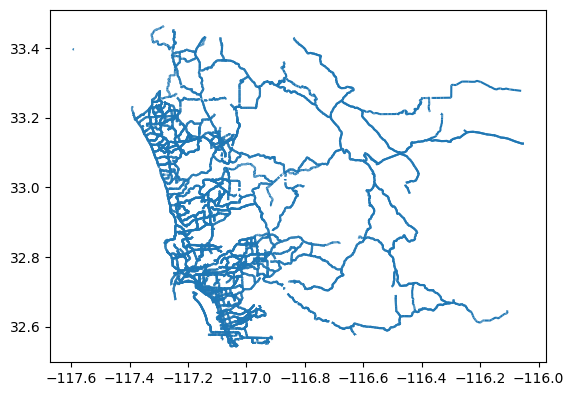

In [81]:
road_gdf.plot()

<Axes: >

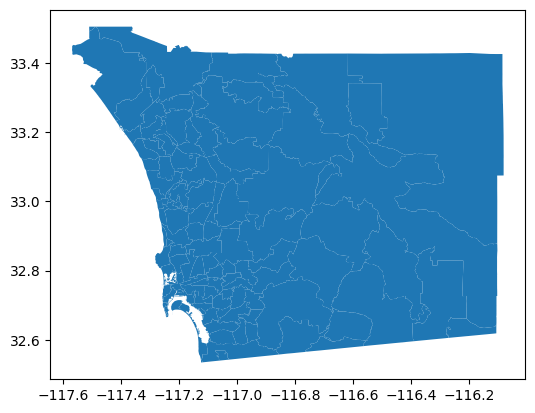

In [80]:
enriched_gdf_4326.plot()

In [123]:
combined_gdf = enriched_gdf_4326.sjoin(road_gdf, how = 'inner', predicate = 'intersects')

In [124]:
combined_gdf.shape

(79093, 36)

In [125]:
combined_gdf.head(5)

,FID,zip_code,po_name,state,totpop_cy1,totpop_cy,pop_sqmi_l,medmage_cy,medfage_cy,medage_cy,...,osm_id,Street Name,Highway,Lanes,Speed Limit MPH,Length,Direction,PeakPeriod,Speed 2022 MPH,2022 AADT Range
0,1,92069,San Marcos,CA,49308,48618.0,2684.16,34.6,36.6,35.6,...,4.362646e+08,"West San Marcos Boulevard, S12",primary,5.0,40.0,121.12,SW,PM,19.0,"20,000-39,999"
0,1,92069,San Marcos,CA,49308,48618.0,2684.16,34.6,36.6,35.6,...,4.362646e+08,"West San Marcos Boulevard, S12",primary,5.0,40.0,121.12,SW,AM,20.1,"20,000-39,999"
0,1,92069,San Marcos,CA,49308,48618.0,2684.16,34.6,36.6,35.6,...,1.033837e+09,"West San Marcos Boulevard, S12",primary,3.0,40.0,17.05,SW,AM,20.1,"20,000-39,999"
0,1,92069,San Marcos,CA,49308,48618.0,2684.16,34.6,36.6,35.6,...,1.033837e+09,"West San Marcos Boulevard, S12",primary,3.0,40.0,17.05,SW,PM,19.0,"20,000-39,999"
0,1,92069,San Marcos,CA,49308,48618.0,2684.16,34.6,36.6,35.6,...,4.362639e+08,"West Mission Road, S14",primary,-1.0,40.0,79.38,W,PM,29.8,"10,000-19,999"


In [126]:
combined_gdf.columns

Index(['FID', 'zip_code', 'po_name', 'state', 'totpop_cy1', 'totpop_cy',
       'pop_sqmi_l', 'medmage_cy', 'medfage_cy', 'medage_cy', 'white_cy_p',
       'black_cy_p', 'amerind_cy', 'asian_cy_p', 'pacific_cy', 'othrace_cy',
       'race2up_cy', 'hisppop_cy', 'medhinc_cy', 'acsspnoa18', 'acsapnoa18',
       'pacshhbpov', 'Shape__Area', 'Shape__Length', 'SHAPE', 'index_right',
       'osm_id', 'Street Name', 'Highway', 'Lanes', 'Speed Limit MPH',
       'Length', 'Direction', 'PeakPeriod', 'Speed 2022 MPH',
       '2022 AADT Range'],
      dtype='object')

In [142]:
combined_gdf.SHAPE

0      MULTIPOLYGON (((-117.20795 33.15613, -117.2078...
0      MULTIPOLYGON (((-117.20795 33.15613, -117.2078...
0      MULTIPOLYGON (((-117.20795 33.15613, -117.2078...
0      MULTIPOLYGON (((-117.20795 33.15613, -117.2078...
0      MULTIPOLYGON (((-117.20795 33.15613, -117.2078...
                             ...                        
109    MULTIPOLYGON (((-117.08101 32.77559, -117.0806...
109    MULTIPOLYGON (((-117.08101 32.77559, -117.0806...
109    MULTIPOLYGON (((-117.08101 32.77559, -117.0806...
109    MULTIPOLYGON (((-117.08101 32.77559, -117.0806...
109    MULTIPOLYGON (((-117.08101 32.77559, -117.0806...
Name: SHAPE, Length: 79093, dtype: geometry

In [141]:
shrunk_gdf = combined_gdf[['zip_code', 'Speed 2022 MPH', 'SHAPE']]

In [146]:
shrunk_gdf.zip_code.unique()

<StringArray>
['92069', '92067', '92066', '92065', '92064', '92093', '92061', '92101',
 '92102', '92060',
 ...
 '92126', '92128', '92130', '92134', '92139', '92145', '92152', '92154',
 '92173', '92182']
Length: 106, dtype: string

In [147]:
shrunk_gdf.head(5)

,zip_code,Speed 2022 MPH,SHAPE
0,92069,19.0,"MULTIPOLYGON (((-117.20795 33.15613, -117.2078..."
0,92069,20.1,"MULTIPOLYGON (((-117.20795 33.15613, -117.2078..."
0,92069,20.1,"MULTIPOLYGON (((-117.20795 33.15613, -117.2078..."
0,92069,19.0,"MULTIPOLYGON (((-117.20795 33.15613, -117.2078..."
0,92069,29.8,"MULTIPOLYGON (((-117.20795 33.15613, -117.2078..."


In [148]:
type(shrunk_gdf)

geopandas.geodataframe.GeoDataFrame

In [154]:
shrunk_gdf.loc[~shrunk_gdf.geometry.is_valid]

,zip_code,Speed 2022 MPH,SHAPE
12,92106,24.0,"MULTIPOLYGON (((-117.23946 32.70183, -117.2397..."
12,92106,28.5,"MULTIPOLYGON (((-117.23946 32.70183, -117.2397..."
12,92106,26.0,"MULTIPOLYGON (((-117.23946 32.70183, -117.2397..."
12,92106,24.0,"MULTIPOLYGON (((-117.23946 32.70183, -117.2397..."
12,92106,22.6,"MULTIPOLYGON (((-117.23946 32.70183, -117.2397..."
...,...,...,...
12,92106,28.0,"MULTIPOLYGON (((-117.23946 32.70183, -117.2397..."
94,92118,53.0,"MULTIPOLYGON (((-117.15664 32.66883, -117.1567..."
94,92118,55.8,"MULTIPOLYGON (((-117.15664 32.66883, -117.1567..."
94,92118,52.4,"MULTIPOLYGON (((-117.15664 32.66883, -117.1567..."


In [155]:
shrunk_gdf.geometry = shrunk_gdf.geometry.make_valid()

c:\Users\lukas\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [159]:
test_gdf = shrunk_gdf.to_crs("EPSG:26911")

In [ ]:
# This dissolve takes over 10 minutes on my rig, use the arcgis feature layer instead

disolved_gdf = test_gdf.dissolve(by = 'zip_code', aggfunc = {'Speed 2022 MPH': 'mean'}, as_index=False)

In [163]:
disolved_gdf.head(5)

,zip_code,SHAPE,Speed 2022 MPH
0,91901,"POLYGON ((516517.474 3634143.028, 516516.527 3...",39.878084
1,91902,"POLYGON ((493186.84 3613285.704, 493198.094 36...",30.051107
2,91905,"POLYGON ((556975.821 3612470.042, 557068.718 3...",42.263333
3,91906,"POLYGON ((530659.069 3618329.525, 530668.469 3...",46.178797
4,91910,"POLYGON ((490031.974 3611905.236, 489995.886 3...",23.263709


In [173]:
# Feature layer for disolved data
dissolve_sdf = GeoAccessor.from_geodataframe(
    disolved_gdf, column_name = "SHAPE"
)
feature_layer = dissolve_sdf.spatial.to_featurelayer(
    title = "Speed Data SD County 2022",
    gis = gis, 
    tags = ["Road", "Data", "2022"],
    overwrite = False,
    sanitize_columns = True,
    service_name = "Speed_Zip_SD_County_2022"
)

In [174]:
gis.content.search(
    query=f"owner:{arcgiskey.USERNAME}", item_type="Feature Layer"
)

[<Item title:"Enriched San Diego County Zip Codes" type:Feature Layer Collection owner:dsc170wi25_7>,
 <Item title:"San Diego County Zip Codes" type:Feature Layer Collection owner:dsc170wi25_7>,
 <Item title:"Road Data SD County 2022" type:Feature Layer Collection owner:dsc170wi25_7>,
 <Item title:"Collision Data SD County 2022" type:Feature Layer Collection owner:dsc170wi25_7>,
 <Item title:"Speed Data SD County 2022" type:Feature Layer Collection owner:dsc170wi25_7>]

In [2]:
speed_layer = gis.content.search(
    query=f"owner:{arcgiskey.USERNAME} Speed", item_type="Feature Layer"
)[0]
speed_fl = gis.content.get(speed_layer.id).layers[0]
speed_sdf = speed_fl.query().sdf

In [3]:
speed_sdf.head(5)
speed_sdf.speed_2022.max()
speed_sdf.columns

Index(['FID', 'zip_code', 'speed_2022', 'Shape__Area', 'Shape__Length',
       'SHAPE'],
      dtype='object')

In [14]:
map7 = gis.map("San Diego, CA")
# Apply a graduated colors renderer
speed_median_renderer = {
    "type": "classBreaks",
    "field": "speed_2022	",
    "classificationMethod": "esriClassifyQuantile",
    "minValue": 0.0,
    "maxValue": 61.0,
    "defaultSymbol": {
        "type": "esriSFS",
        "style": "esriSFSSolid",
        "color": [255, 255, 255, 100],
        "outline": {
            "type": "esriSLS",
            "style": "esriSLSSolid",
            "color": [110, 110, 110, 255],
            "width": 0.5,
        },
    },
    "defaultLabel": "No Data",
    "legendOptions": {"title": "Median Household Income of the Zip Code"},
    "classBreakInfos": [
        {
            "classMaxValue": np.percentile(speed_sdf["speed_2022"], 25),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [164, 255, 0, 180],  # Light blue-green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"$ - {np.round(np.percentile(speed_sdf['speed_2022'], 25), 2)}: 0th-25th Percentile",
        },
        {
            "classMaxValue": np.percentile(speed_sdf["speed_2022"], 50),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [255, 244, 0, 180],  # Medium blue-green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"${np.round(np.percentile(speed_sdf['speed_2022'], 25), 2)} - {np.round(np.percentile(speed_sdf['speed_2022'], 50), 2)}: 25th-50th Percentile",
        },
        {
            "classMaxValue": np.percentile(speed_sdf["speed_2022"], 75),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [255, 167, 0, 180],  # Darker blue-green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"${np.round(np.percentile(speed_sdf['speed_2022'], 50), 2)} - {np.round(np.percentile(speed_sdf['speed_2022'], 75), 2)}: 50th-75th Percentile",
        },
        {
            "classMaxValue": np.percentile(speed_sdf["speed_2022"], 100),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [255, 0, 0, 180],  # Dark green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"${np.round(np.percentile(speed_sdf['speed_2022'], 75), 2)}+: 75th-100th Percentile",
        },
    ],
}


# Add the layer with the heatmap renderer to your map
map7.content.add(speed_fl, drawing_info={"renderer": speed_median_renderer})
map7.content.add(road_fl, drawing_info={"renderer": road_renderer})
map7.legend.enabled = True
map7

Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13075789.689488532, 'ymin': 3818273.910…

In this graph we begin to draw comparisons between road speeds and the actual structures of the roads themselves.  Each space on the map represesnts a zip code, and the color represents the average speed on all the roads in the zip code.  We have then overlayed the road data from earlier, and we can begin seeing some trends.  In the speed data red is the fastest, around 60 mph average speed, wheras yellow is closer to 30 mph.  And the road data lighter colors represent more lanes, so those blue roads are 1 lane, wheras the green and cyan are 3 and 4 lane roads.  One would expect larger roads to lead to faster traffic, but actually analyzing the data shows trends of the larger roads actually having slower average speeds!  As we progress this project we will perform more analysis like this, attempting to locate more factors that determine average speed over an area, and of course seeing how those relate to crashes.

# 8) Expected Spatial Data Integration Issues

Some issues of the data could be that the San Diego county data might use NAD83 state plane EPSG:2230 while others might use EPSG:4326 which can be an easy fix. There might be temporal alignment issues however, as there could be time issues between years like 2020 or 2023. There might even be incomplete data from say, 2024. 


# 9) Demonstration

In [15]:
road_layer = gis.content.search(query=f"owner:dsc170wi25_7 Road", item_type="Feature Layer")[0]
road_fl = gis.content.get(road_layer.id).layers[0]
road_sdf = road_fl.query().sdf

In [ ]:
map3 = gis.map("San Diego, CA")

road_renderer = {
    "type": "classBreaks",
    "field": "lanes",  # Attribute that determines line width
    "defaultSymbol": {
        "type": "esriSLS",
        "style": "esriSLSSolid",
        "color": [128, 128, 128, 255],  # Gray color for undefined values
        "width": 1  # Default width
    },
    "classBreakInfos": [
        {
            "classMinValue": 1,
            "classMaxValue": 1,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [0,0,255, 255], 
                "width": 1.5  
            }
        },
        {
            "classMinValue": 2,
            "classMaxValue": 2,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [64,224,208, 255],
                "width": 2  
            }
        },
        {
            "classMinValue": 3,
            "classMaxValue": 3,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [0,255,127, 255], 
                "width": 2.5  
            }
        },
        {
            "classMinValue": 4,
            "classMaxValue": 4,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [127,255,0, 255],
                "width": 3 
            }
        },
        {
            "classMinValue": 5,
            "classMaxValue": 5,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [255,255,0, 255], 
                "width": 3.5  
            }
        },
        {
            "classMinValue": 6,
            "classMaxValue": 6,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [255,140,0, 255], 
                "width": 4 
            }
        },
        {
            "classMinValue": 7,
            "classMaxValue": 7,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [220,20,60, 255],
                "width": 4.5  
            }
        }
    ]
}

map3.content.add(road_fl, drawing_info={"renderer": road_renderer})
map3.legend.enabled = True
map3

Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13075789.689488532, 'ymin': 3818273.910…

In [17]:
speed_layer = gis.content.search(
    query=f"owner:dsc170wi25_7 Speed", item_type="Feature Layer"
)[0]
speed_fl = gis.content.get(speed_layer.id).layers[0]
speed_sdf = speed_fl.query().sdf

In [18]:
map7 = gis.map("San Diego, CA")
# Apply a graduated colors renderer
speed_median_renderer = {
    "type": "classBreaks",
    "field": "speed_2022	",
    "classificationMethod": "esriClassifyQuantile",
    "minValue": 0.0,
    "maxValue": 61.0,
    "defaultSymbol": {
        "type": "esriSFS",
        "style": "esriSFSSolid",
        "color": [255, 255, 255, 100],
        "outline": {
            "type": "esriSLS",
            "style": "esriSLSSolid",
            "color": [110, 110, 110, 255],
            "width": 0.5,
        },
    },
    "defaultLabel": "No Data",
    "legendOptions": {"title": "Median Household Income of the Zip Code"},
    "classBreakInfos": [
        {
            "classMaxValue": np.percentile(speed_sdf["speed_2022"], 25),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [164, 255, 0, 180],  # Light blue-green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"$ - {np.round(np.percentile(speed_sdf['speed_2022'], 25), 2)}: 0th-25th Percentile",
        },
        {
            "classMaxValue": np.percentile(speed_sdf["speed_2022"], 50),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [255, 244, 0, 180],  # Medium blue-green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"${np.round(np.percentile(speed_sdf['speed_2022'], 25), 2)} - {np.round(np.percentile(speed_sdf['speed_2022'], 50), 2)}: 25th-50th Percentile",
        },
        {
            "classMaxValue": np.percentile(speed_sdf["speed_2022"], 75),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [255, 167, 0, 180],  # Darker blue-green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"${np.round(np.percentile(speed_sdf['speed_2022'], 50), 2)} - {np.round(np.percentile(speed_sdf['speed_2022'], 75), 2)}: 50th-75th Percentile",
        },
        {
            "classMaxValue": np.percentile(speed_sdf["speed_2022"], 100),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [255, 0, 0, 180],  # Dark green with 70% opacity
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": f"${np.round(np.percentile(speed_sdf['speed_2022'], 75), 2)}+: 75th-100th Percentile",
        },
    ],
}


# Add the layer with the heatmap renderer to your map
map7.content.add(speed_fl, drawing_info={"renderer": speed_median_renderer})
map7.content.add(road_fl, drawing_info={"renderer": road_renderer})
map7.legend.enabled = True
map7

Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13075789.689488532, 'ymin': 3818273.910…